# Train an image classification model in PyTorch and convert to ONNX format for inferencing

We are going to train an image classifier using sports images belonging to these categories:
- badminton
- bocce
- croquet
- polo
- RockClimbing
- rowing
- sailing
- snowboarding

We'll use PyTorch to build a DNN with resnet architecture and initialised with the weights of a pre-trained resnet model.

### Fetch the data and extract it.

In [ ]:
%%bash
wget http://vision.stanford.edu/lijiali/event_dataset/event_dataset.rar
sudo apt-get install unrar
unrar x event_dataset.rar

In [45]:
%%bash
ls event_img

badminton
bocce
croquet
polo
RockClimbing
rowing
sailing
snowboarding


### Install the required Python packages from requirements.txt.

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 3.4MB 37.4MB/s eta 0:00:01


### Import the necessary packages.

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)
from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

%matplotlib inline

### Pre-trained models in PyTorch

In [5]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print (model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


### Training hyper-parameters and other variables

In [55]:
model_name = 'resnet18'
num_workers = 2
num_epochs = 2
batch_size = 32
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
dropout_p = 0.4
decay_rate = 0.9999
max_grad_norm = 5.0
log_interval = 1
num_classes = 8

# reproduceability
seed = 42
torch.manual_seed(seed)

### Load the data, split it among train, test and validation set after applying a series of transforms.
dataset.ImageFolder() is a generic data loader where the images are arranged under a root folder, with sub-folders named same as the class-labels and containing the corresponding images. Here, we pass the image_folder and apply a set of data transforms.<br>
1) RandomResizedCrop()- Crop the given PIL Image to random size and aspect ratio. This crop is finally resized to given size.<br>
2) RandomHorizontalFlip()- Horizontally flip the given PIL Image randomly with a given probability(default 0.5).<br>
3) ToTensor()- Convert a PIL Image or numpy.ndarray to tensor.<br>
4) Normalize()- Normalize a tensor image with mean and standard deviation.<br>
random_split() is used to randomly split the dataset into non-overlapping train, test and validation sets given lengths.<br>
Dataloader() provides an iterable over the given dataset.

In [73]:
image_folder = 'event_img/'
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.47637546, 0.485785  , 0.4522678 ], [0.24692202, 0.24377407, 0.2667196 ])
    ])
data = datasets.ImageFolder(root=image_folder, transform=data_transforms)
class_names = data.classes
train_len, val_len = int(len(data) * 0.75), int(len(data) * 0.2)
test_len = len(data) - train_len - val_len
train_set, val_set, test_set = torch.utils.data.random_split(data, [train_len, val_len, test_len])
loader = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
}

In [74]:
class_names

['RockClimbing',
 'badminton',
 'bocce',
 'croquet',
 'polo',
 'rowing',
 'sailing',
 'snowboarding']

In [9]:
print(f'Number of training set images = {train_len},\n'
      f'Number of validation set images = {val_len},\n'
      f'Number of test set images = {test_len}')

Number of training set images = 1184,
Number of validation set images = 315,
Number of test set images = 80


### Visualise a few training examples.

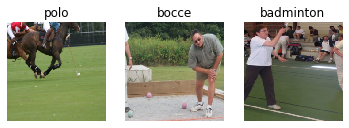

In [10]:
batch = next(iter(loader['train']))
samples = batch[0][:3]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 3, i+1)
    plt.title(f'{class_names[y_true[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

### Pick one of the pre-trained models, replace its final layer setting its output to the number of classes.

In [75]:
model = models.__dict__[model_name](pretrained=True) # Set false to train from scratch
# Alter the final layer
final_layer_input = model.fc.in_features
# nn.Linear a linear transformation to the incoming data: y = x A^T + b
model.fc = nn.Linear(final_layer_input, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay,
                     )
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Using pre-trained weights

In [76]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221

### Train the model

In [77]:
def process_batch(inputs, targets, model, criterion, optimizer, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # In PyTorch, we need to set the gradients to zero before starting to
        # do backpropragation because PyTorch accumulates the gradients on subsequent
        # backward passes.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [78]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm):
    """
    Training the model.
    """
    
    # Metrics
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []

    # Training
    for num_train_epoch in range(num_epochs):
        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss, train_batch_accuracy = 0.0, 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):
            # Get metrics
            model.train()
            loss, accuracy = process_batch(
                inputs, target, model, criterion, optimizer, model.training)
            
            # Add to batch scalars
            train_batch_loss += loss.data.item() / float(len(inputs))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss / float(train_batch_num+1))
        train_acc.append(train_batch_accuracy / float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):
            # Metrics
            test_batch_loss, test_batch_accuracy = 0.0, 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):
                # Get metrics
                model.eval()
                loss, accuracy = process_batch(
                    inputs, target, model, criterion, optimizer, model.training)
                # Add to batch scalars
                test_batch_loss += loss.data.item() / float(len(inputs))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss / float(test_batch_num+1))
            test_acc.append(test_batch_accuracy / float(test_batch_num+1))
                

            verbose_condition = ((num_train_epoch == 0) or (num_train_epoch % log_interval == 0) 
                                 or (num_train_epoch == num_epochs-1))

            # Verbose
            if verbose_condition:
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch + 1))
                minutes = time_remain // 60
                seconds = time_remain - minutes * 60
                print(f'TIME REMAINING: {minutes:.0f}m {seconds:.0f}s')
                print(f'[EPOCH]: {num_train_epoch},'
                      f'[TRAIN LOSS]: {train_batch_loss / float(train_batch_num+1):.6f},'
                      f'[TRAIN ACC]: {train_batch_accuracy / float(train_batch_num+1):.3f},'
                      f'[VAL LOSS]: {test_batch_loss / float(test_batch_num+1):.6f},'
                      f'[VAL ACC]: {test_batch_accuracy / float(test_batch_num+1):.3f}')
    return model

In [79]:
model = train(model, criterion, optimizer, loader['train'], loader['val'],
              num_epochs, batch_size, log_interval, learning_rate,
              dropout_p, decay_rate, max_grad_norm)

TIME REMAINING: 3m 0s
[EPOCH]: 0,[TRAIN LOSS]: 0.020398,[TRAIN ACC]: 0.774,[VAL LOSS]: 0.011379,[VAL ACC]: 0.891
TIME REMAINING: 0m 0s
[EPOCH]: 1,[TRAIN LOSS]: 0.007084,[TRAIN ACC]: 0.926,[VAL LOSS]: 0.006557,[VAL ACC]: 0.924


### Inference

In [80]:
def infer(model, inputs):
    """
    Inference.
    """
    
    # Convert tensors to Variables (for autograd)
    X_batch = Variable(inputs, requires_grad=False)
    # Forward pass
    scores = model(X_batch)  # logits
    score, predicted = torch.max(scores, 1)
    return predicted

### Run prediction on a few images from test set

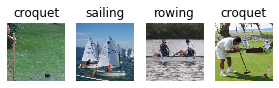

In [81]:
# Visualise some predictions
batch = next(iter(loader['test']))
samples = batch[0][:4]
y_preds = infer(model, samples)
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title(f'{class_names[y_preds[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

## Inferencing with ONNX and ONNX Runtime


### Conversion to ONNX
First, we will export this model to the interoperable ONNX format. 

In [82]:
dummy_input = torch.randn(4, 3, 224, 224)
torch.onnx.export(model, dummy_input, "sports_classification-pretrained.onnx")

### Visualise using Netron

Visualise the ONNX model using Netron: https://lutzroeder.github.io/netron/

### To inference with the ONNX format, we'll be using [ONNX Runtime](https://aka.ms/onnxruntime).

#### Load ONNX model

In [83]:
from onnxruntime import InferenceSession

ort_session = InferenceSession('sports_classification-pretrained.onnx')

#### Run prediction on ONNX model

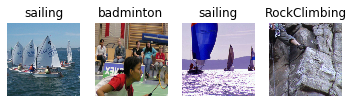

In [85]:
# Visualise onnx predictions
batch = next(iter(loader['test']))
samples = batch[0][:4]
outputs = np.argmax(ort_session.run(None, {'input.1': samples.numpy()})[0], axis=1)
for i, sample in enumerate(samples):
    plt.subplot(1, 4, i+1)
    plt.title(f'{class_names[outputs[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

## Connect to your AML Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. The workspace holds all your experiments, compute targets, models, datastores, etc.

You can open [ml.azure.com](https://ml.azure.com/) to access your workspace resources through a graphical user interface of Azure Machine Learning studio.

If you've already created a workspace, we can load it now. Import the Workspace class, and load your subscription information from the file config.json using the function from_config(). This looks for the JSON file in the current directory by default, but you can also specify a path parameter to point to the file using from_config(path="your/file/path"). **In a cloud notebook server, the file is automatically in the root directory.**

In [86]:
from azureml.core.workspace import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: prroy-odsc-19nov
Azure region: westeurope
Resource group: prroy-rg


#### Convert your model to onnx for atomic prediction.

In [87]:
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(model, dummy_input, "sports_classification-atomic.onnx")

## Register your trained model
To keep track of our models from various runs we may be testing, we will register the model from the run to our workspace. The model_path parameter takes in the relative path on the remote VM to the model file in your outputs directory. You can then deploy this registered model as a web service through the AML SDK.

In [88]:
model_path = 'sports_classification-atomic.onnx'
model = Model.register(workspace = ws,
               model_path = model_path,
               model_name = "sports_classification-atomic",
               tags = {"onnx": "demo"},
               description = "Sports image classification")
print(model.name, model.id, model.version, sep = '\t')

Registering model sports_classification-atomic
sports_classification-atomic	sports_classification-atomic:1	1


## Deploying your model as a web service
Now we are ready to [deploy](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where) the model as a web service. For this notebook we will deploy this to run on an Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/), but you can alternatively also run on your [local](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#local) machine or with Azure Kubernetes Service [AKS](https://azure.microsoft.com/en-us/services/kubernetes-service/). 

Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in. We will deploy our ONNX model on Azure ML using ONNX Runtime inference engine. 

**To build the correct environment, provide the following:**

* A scoring script to show how to use the model
* An environment file to show what packages need to be installed
* A configuration file to build the web service
* The model you trained before

### Write scoring file
We begin by writing a score.py file that will be invoked by the web service call.

Note that the scoring script must have two required functions, init() and run(input_data).
* The **init()** function is called once when the container is started so we load the model using the ONNX Runtime into a global session object. This function is executed only once when the Docker container is started.
* In **run(input_data)** function, the model is used to predict a value based on the input data. The input and output to run typically use JSON as serialization and de-serialization format but you are not limited to that.

In [89]:
%%writefile score.py
import json
import time
import sys
import os
from PIL import Image
import requests
from io import BytesIO
from azureml.core.model import Model
import numpy as np
from onnxruntime import InferenceSession
from torchvision import transforms

def init():
    global session
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_onnx = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sports_classification-atomic.onnx')
    session = InferenceSession(model_onnx)

def preprocess(input_data_json):
    input_url = json.loads(input_data_json)['data'][0]
    # convert the image url into the tensor input
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.47637546, 0.485785  , 0.4522678 ], [0.24692202, 0.24377407, 0.2667196 ])
    ])  
    response = requests.get(input_url)
    image = Image.open(BytesIO(response.content))
    image = data_transforms(image)
    image = image.numpy().reshape((1, *image.shape))
    return image

def postprocess(result):
    class_names = [ 
        'RockClimbing',
        'badminton',
        'bocce',
        'croquet',
        'polo',
        'rowing',
        'sailing',
        'snowboarding'
    ]   
    return class_names[np.argmax(result[0])]

def run(input_data_json):
    try:
        start = time.time()   # start timer
        input_data = preprocess(input_data_json)
        input_name = session.get_inputs()[0].name  # get the id of the first input of the model   
        result = session.run(None, {input_name: input_data})
        end = time.time()     # stop timer
        return {"result": postprocess(result),
                "time": end - start}
    except Exception as e:
        result = str(e)
        return {"error": result}

Overwriting score.py


### Set the evironment and inference configurations
First we create a YAML file that specifies which dependencies we would like to see in our container.

In [90]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy","onnxruntime","azureml-core", "Pillow", "torchvision"])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

Then we setup the [inference configuration](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.inferenceconfig?view=azure-ml-py).

In [91]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml",
                                   extra_docker_file_steps = "Dockerfile")

### Deploy the model using [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/container-instances-overview)
**Estimated time to complete: about 3-7 minutes**

Configure the image and deploy.

In [92]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'demo': 'onnx'}, 
                                               description = 'web service for sports classification ONNX model')

The following code goes through these steps:

Build an image using:
* The scoring file (score.py)
* The environment file (myenv.yml)
* The model file
* Define ACI Deployment Configuration
* Send the image to the ACI container.
* Start up a container in ACI using the image.
* Get the web service HTTP endpoint.

In [93]:
from azureml.core.model import Model
from random import randint

aci_service_name = f'onnx-sports{randint(0,100)}'
print("Service", aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

Service onnx-sports95
Creating image
Running.........................................................
Succeeded
Image creation operation finished for image onnx-sports95:1, operation "Succeeded"
Running..................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In case the deployment fails, you can check the logs. Make sure to delete your aci_service before trying again.

In [94]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())
    aci_service.delete()

### Success!
If you've made it this far, you've deployed a working web service that does sports image classification using an ONNX model. You can get the URL for the webservice with the code below.

In [95]:
service_url = aci_service.scoring_uri
service_url

'http://780f7dba-e204-487d-8c27-7f4773b887a2.westeurope.azurecontainer.io/score'

## Test the service
To submit sample data to the running service, use the following code.

In [96]:
from IPython.display import Image

image_name = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/DN_ice_boat--Ice_Nine--Lake_Sunapee_NH.jpg/220px-DN_ice_boat--Ice_Nine--Lake_Sunapee_NH.jpg'
Image(url=image_name)

In [97]:
import requests
import json
test_sample = json.dumps({'data': [
    image_name
]})
test_sample = bytes(test_sample, encoding = 'utf8')
headers = {'Content-Type':'application/json'}
resp = requests.post(service_url, test_sample, headers=headers)
print("prediction:", resp.text)

prediction: {"result": "sailing", "time": 0.2891874313354492}
